# Train A Shape Classifier Model



In [1]:
import json
import os

train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (including resizing and normalization)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (black and white images)
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_data_root, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names (optional)
print(f'Classes: {train_dataset.classes}')

# 2. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: circle, triangle, rectangle
        
    def forward(self, x):
        x = F.relu(self.conv1(x))   # First Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = F.relu(self.conv2(x))   # Second Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))     # Fully Connected Layer 1
        x = self.fc2(x)             # Fully Connected Layer 2 (output)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


Classes: ['circle', 'diamond', 'triangle']


# Train

In [3]:
train_model(model, train_loader, criterion, optimizer, epochs=15)

Epoch [1/15], Loss: 1.1637, Accuracy: 32.71%
Epoch [2/15], Loss: 1.0782, Accuracy: 36.00%
Epoch [3/15], Loss: 1.0146, Accuracy: 48.71%
Epoch [4/15], Loss: 0.9366, Accuracy: 54.86%
Epoch [5/15], Loss: 0.8362, Accuracy: 61.29%
Epoch [6/15], Loss: 0.7207, Accuracy: 67.14%
Epoch [7/15], Loss: 0.5859, Accuracy: 76.43%
Epoch [8/15], Loss: 0.4584, Accuracy: 81.29%
Epoch [9/15], Loss: 0.3422, Accuracy: 88.86%
Epoch [10/15], Loss: 0.2567, Accuracy: 92.57%
Epoch [11/15], Loss: 0.2028, Accuracy: 93.57%
Epoch [12/15], Loss: 0.1408, Accuracy: 96.57%
Epoch [13/15], Loss: 0.1064, Accuracy: 97.43%
Epoch [14/15], Loss: 0.0809, Accuracy: 97.57%
Epoch [15/15], Loss: 0.0598, Accuracy: 98.86%


# Test 

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score

def test(model, test_loader):
    """Print the Precision, Recall and F1-score for the trained model
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []  # To store true labels
    all_predictions = []  # To store predictions

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            
            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_predictions.extend(predicted.cpu().numpy())  # Store predictions

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Print results
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')


# Show Predictions


In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def show_prediction(model, image):
    """Pass the image to the model and overlay the predicted shape and confidence on the input
    image and display it.
    """
    # Define transformations for the input image
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Ensure the image is in grayscale
        transforms.Resize((64, 64)),  # Resize to the model input size
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize the image
    ])

    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():  # Disable gradient calculation
        # Pass the image through the model
        output = model(image_tensor.to(device))
        probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities
        confidence, predicted_class = torch.max(probabilities, 1)  # Get the predicted class and confidence

    # Convert the predicted class to label (assuming class indices are 0, 1, 2)
    class_labels = ['circle', 'triangle', 'rectangle']  # Modify according to your class labels
    predicted_label = class_labels[predicted_class.item()]
    confidence_value = confidence.item()

    # Display the image with the prediction overlay
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted: {predicted_label} (Confidence: {confidence_value:.2f})')
    plt.axis('off')  # Hide axes
    plt.show()


In [6]:
test(model, test_loader)



Precision: 0.7265
Recall: 0.7267
F1-score: 0.7264


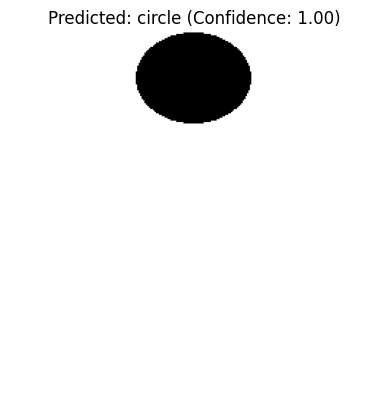

In [7]:
from PIL import Image  # Import Image from PIL

image_path = "../datasets/test/circle/circle_285.png" # Replace with the actual image path
image = Image.open(image_path).convert("L") 
# Run the show_prediction function
show_prediction(model, image)